In [106]:
import cv2
import copy
import torch
import numpy as np
import open3d as o3d
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from moge.model.v2 import MoGeModel

from superprimitive_fusion.scanner import (
    capture_spherical_scans,
    virtual_scan,
    virtual_mesh_scan,
    mesh_depth_image,
    generate_rgbd_noise,
    clean_mesh_and_remap_weights,
)
from superprimitive_fusion.utils import (
    bake_uv_to_vertex_colours,
    polar2cartesian,
    distinct_colours,
)
from superprimitive_fusion.mesh_fusion import (
    fuse_meshes,
)
from superprimitive_fusion.mesh_fusion_utils import (
    get_mesh_components,
)

device = torch.device("cuda:0")

In [2]:
model = MoGeModel.from_pretrained("../models/MoGe/moge-2-vitl-normal.pt").to(device)                       

In [3]:
names = (
    ('mustard-bottle', 'mustard-bottle.obj'),
    ('table', 'table.obj'),
    ('power-drill', 'power-drill.obj'),
    ('bleach', 'bleach.obj'),
    ('pitcher', 'pitcher.obj'),
    ('mug', 'mug.obj'),
    ('extra-large-clamp', 'extra-large-clamp-leaning.obj'),
)

gt_meshes = dict()
for foldername,filename in names:
    print(f'Getting the {foldername}')
    
    gt_mesh = o3d.io.read_triangle_mesh(f"../data/posed-meshes/{foldername}/{filename}", enable_post_processing=True)

    bake_uv_to_vertex_colours(gt_mesh)
    gt_mesh.compute_vertex_normals()

    gt_meshes[foldername] = gt_mesh

gt_mesh_list = list(gt_meshes.values())

centres = []
for gt_meshname, gt_mesh in gt_meshes.items():
    if gt_meshname == 'table':
        continue
    centres.append(gt_mesh.get_center())

centres = np.vstack(centres)

obj_centre = centres.mean(axis=0)

Getting the mustard-bottle
Getting the table
Getting the power-drill
Getting the bleach
Getting the pitcher
Getting the mug
Getting the extra-large-clamp


In [237]:
cam_offset=obj_centre
look_at = obj_centre
width: int = 360
height: int = 240
fov: float = 70.0
k: float = 10
lat: float = 60 # [45, 90]
radius = 0.5 # [0.5, 1.2]
max_normal_angle_deg = None
N = 1
include_depth_images = True

obj_scans = capture_spherical_scans(
    gt_mesh_list,
    N,
    radius,
    look_at,
    cam_offset,
    width,
    height,
    fov,
    k,
    max_normal_angle_deg,
    "latlong",
    linear_depth_sigma=0.001,
    quadrt_depth_sigma=0.001,
    sigma_floor=0,
    grazing_lambda=1,
    bias_k1=0.05,
    include_depth_images=include_depth_images,
    scan_lat=lat,
)
print(obj_scans[0].keys())
mesh, weights, depth_info = obj_scans[0]['mesh']
print(depth_info.keys())

normals = np.zeros
# plt.imshow(depth_info['rgb'])

dict_keys(['mesh', 'cam_centre', 'look_at'])
dict_keys(['depth', 'rgb', 'E', 'K_t'])


/home/christopher/Documents/Code/project/src/superprimitive_fusion/scanner.py:789: RuntimeWarning: invalid value encountered in matmul
  L = look_dir / np.linalg.norm(look_dir)


In [234]:
R_range = (0.5, 1.2)
lat_range = (45, 80)
lon_range = (0, 360)
N = 5
rad = np.random.rand(N) * (R_range[1]-R_range[0]) + R_range[0]
lat = np.random.rand(N) * (lat_range[1]-lat_range[0]) + lat_range[0]
lon = np.random.rand(N) * (lon_range[1]-lon_range[0]) + lon_range[0]
pairs = []
for i in range(N):
    cc = cam_offset + polar2cartesian(r=rad[i], lat=lat[i], long=lon[i])
    scan_result = virtual_scan(
        gt_mesh_list,
        cc,
        look_at,
        width_px=width,
        height_px=height,
        fov=fov,
        up=[0,0,1],
    )

    look_dir = (look_at - cc) / np.linalg.norm(look_at - cc)

    verts_gt = np.flip(scan_result['verts'], axis=0)
    rgb = np.flip(scan_result['vcols'], axis=0)
    normals_gt = np.flip(scan_result['norms'], axis=0)


    rho_gt = np.linalg.norm(verts_gt - cc, axis=2)
    depth_gt = (verts_gt - cc) @ look_dir


    pairs.append(
        {'rgb':rgb,
         'rho_gt':rho_gt,
         'depth_gt':depth_gt,
         'verts_gt':verts_gt,
         'normals_gt':normals_gt,
         'cam_centre':cc,
         'look_dir':look_dir}
    )

/tmp/ipykernel_224714/3727320669.py:29: RuntimeWarning: invalid value encountered in matmul
  depth_gt = (verts_gt - cc) @ look_dir


In [238]:
for pair in pairs:
    cc = pair['cam_centre']
    verts_gt = pair['verts_gt']
    depth_gt = pair['depth_gt']

    input_image = torch.tensor(pair['rgb'].copy(), dtype=torch.float32, device=device).permute(2, 0, 1)
    output = model.infer(input_image)

    depth_pred = output['depth'].squeeze().cpu().numpy()  # ensure (H, W)

    ray = verts_gt - cc
    rho_gt = np.linalg.norm(ray, axis=2)
    ray_hat = ray / (rho_gt[..., None] + 1e-12)

    cos_theta = depth_gt / np.maximum(rho_gt, 1e-12)
    rho_pred = depth_pred / np.clip(cos_theta, 1e-3, 1.0)
    verts_pred = cc + rho_pred[..., None] * ray_hat

    pair['rho_pred'] = rho_pred
    pair['verts_pred'] = verts_pred
    pair['depth_pred'] = depth_pred

/tmp/ipykernel_224714/1383586561.py:13: RuntimeWarning: invalid value encountered in divide
  ray_hat = ray / (rho_gt[..., None] + 1e-12)
/tmp/ipykernel_224714/1383586561.py:15: RuntimeWarning: invalid value encountered in divide
  cos_theta = depth_gt / np.maximum(rho_gt, 1e-12)


In [252]:
for pair in pairs:
    verts_pred = pair['verts_pred'].reshape(-1, 3)
    valid_verts_pred = verts_pred[np.isfinite(verts_pred).all(axis=1)]
    verts_gt = pair['verts_gt'].reshape(-1, 3)
    valid_verts_gt = verts_gt[np.isfinite(verts_gt).all(axis=1)]

    pcd1 = o3d.geometry.PointCloud()
    pcd1.points = o3d.utility.Vector3dVector(valid_verts_pred)
    pcd1.paint_uniform_color([0.8, 0, 0.5])

    pcd2 = o3d.geometry.PointCloud()
    pcd2.points = o3d.utility.Vector3dVector(valid_verts_gt)
    pcd2.paint_uniform_color([0, 0.8, 0.5])

    o3d.visualization.draw_geometries([pcd1, pcd2])


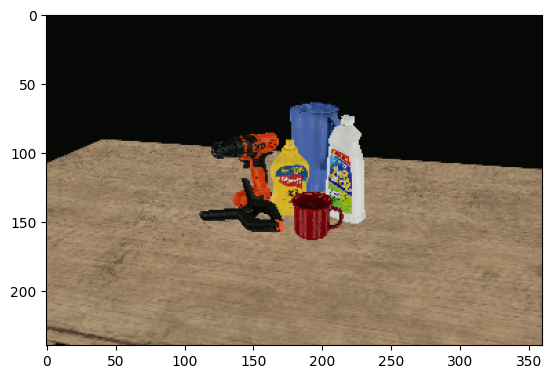

In [251]:
plt.imshow(rgb)

/tmp/ipykernel_224714/4263223524.py:7: RuntimeWarning: invalid value encountered in subtract
  ax.imshow(pair['depth_pred'] - pair['depth_gt'])


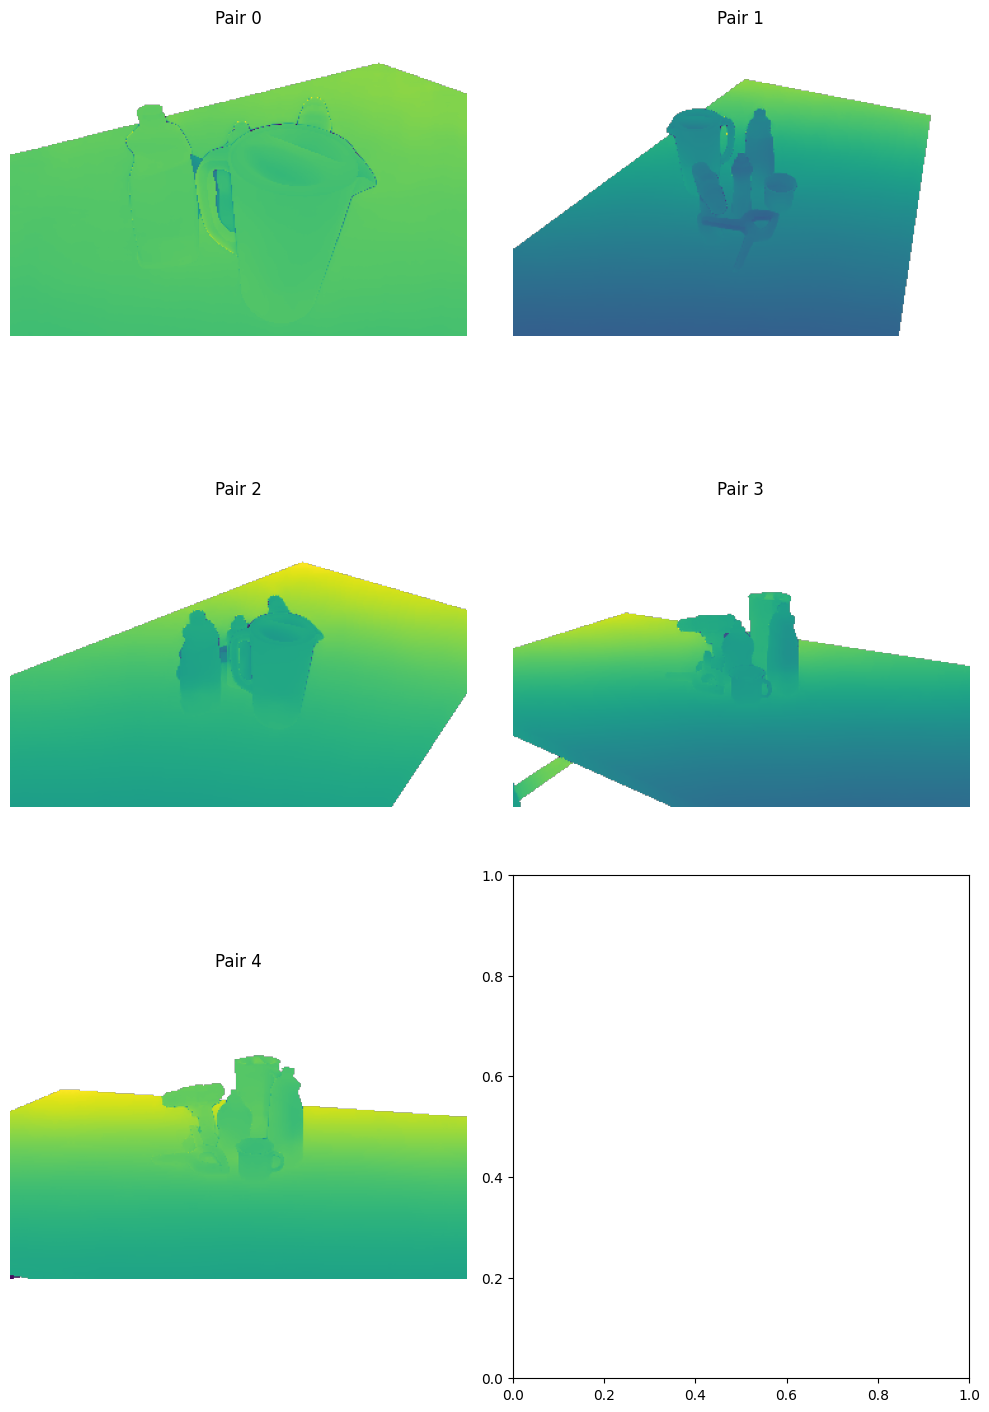

In [248]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))  # 3 rows, 2 columns
axes = axes.flatten()  # easier indexing

for i in range(5):
    pair = pairs[i]
    ax = axes[i]
    ax.imshow(pair['depth_pred'] - pair['depth_gt'])
    ax.set_title(f'Pair {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()